# Motivation 
In this notebook we check the sanity of Time domain data and compute the psd of it 


In [1]:
import numpy as np
from scipy.signal import welch
import matplotlib.pyplot as plt

In [2]:
# first impoort the paths from the config file
from config import settings
from pathlib import Path

settings_type = 'SETTINGS1'
data_path = Path(settings.data.path['raw'])
settings_config = settings.simulation[settings_type]
data_base_path = (data_path/settings_type/settings_type.lower()).with_suffix('.db')

In [3]:
n_samples = settings_config['simu_params']['t_end']/ settings_config['simu_params']['dt']
fs = 1/settings_config['simu_params']['dt']

# PSD checking and RMS computation

In [4]:
# import the TDD_output from the database
import sqlite3
conn = sqlite3.connect(data_base_path)
c = conn.cursor()
c.execute("""SELECT TDD_output FROM simulation""")
TDD_output = np.frombuffer(c.fetchone()[0],dtype=np.float64)
# first impoort the paths from the config file
TDD_output=TDD_output.reshape((int(n_samples),-1))

In [5]:
def compute_psd(signal,fs,nperseg):
    f, psd = welch(signal, fs, nperseg=nperseg, scaling='spectrum')
    return f, psd

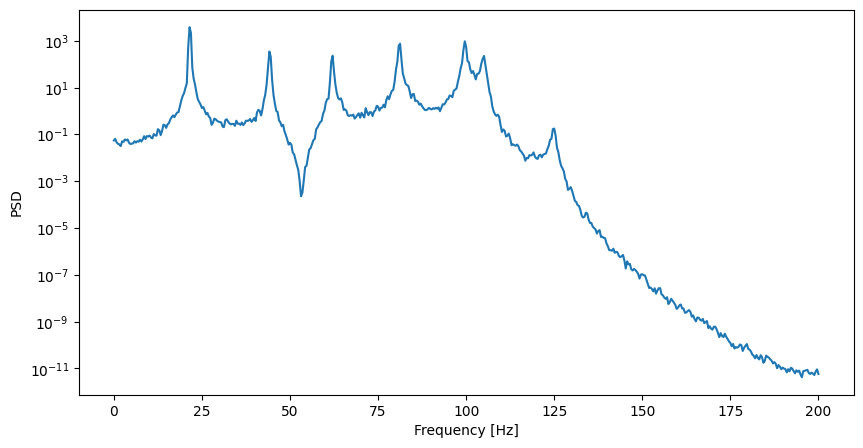

In [6]:
acc_7 = TDD_output[:,2*8+1]
vel_7 = TDD_output[:,1*8+1]
disp_7 = TDD_output[:,0*8+1]


f, psd = compute_psd(acc_7,fs,nperseg=1024)
fig,ax= plt.subplots(figsize=(10,5))
ax.plot(f,psd)
ax.set_ylabel('PSD')
ax.set_xlabel('Frequency [Hz]')
ax.set_yscale('log')

In [7]:
# check is acc and disp and vel are consistent with derivation
# acc is derivative of vel and vel is derivative of disp
acc_7_check = np.diff(vel_7)*fs
vel_7_check = np.diff(disp_7)*fs


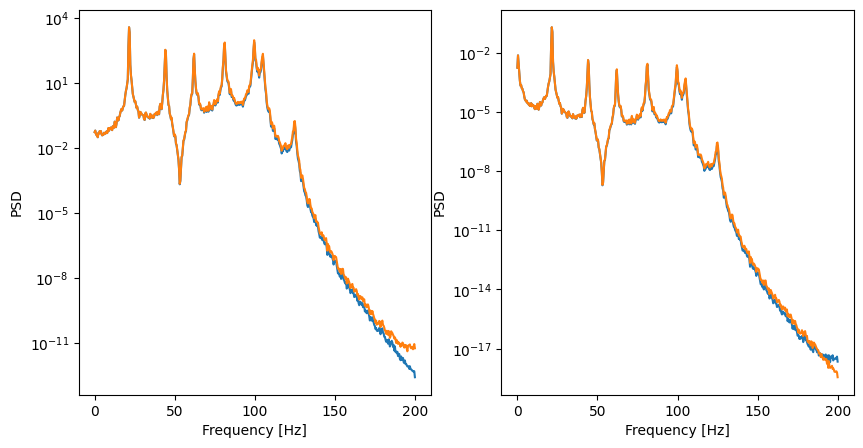

In [8]:
# now lets compare the psds of the acc and acc_check
f, psd_acc_check = compute_psd(acc_7_check,fs,nperseg=1024)
f, psd_acc = compute_psd(acc_7,fs,nperseg=1024)
f, psd_vel_check = compute_psd(vel_7_check,fs,nperseg=1024)
f, psd_vel = compute_psd(vel_7,fs,nperseg=1024)
fig,ax= plt.subplots(ncols=2,figsize=(10,5))
ax[0].plot(f,psd_acc_check)
ax[0].plot(f,psd_acc)
ax[1].plot(f,psd_vel_check)
ax[1].plot(f,psd_vel)
for i in range(2):
    ax[i].set_ylabel('PSD')
    ax[i].set_xlabel('Frequency [Hz]')
    ax[i].set_yscale('log')



In [9]:
def compute_rms(signal):
    return np.sqrt(np.mean(signal**2))
def compute_psd(signal,fs,nperseg):
    f, psd = welch(signal, fs, nperseg=nperseg, scaling='spectrum')
    return f, np.log(psd)

import sqlite3

conn = sqlite3.connect(data_base_path)
c = conn.cursor()
c.execute("""SELECT TDD_output FROM simulation
            WHERE anomaly_level = 0""")

rms = []
max_sig = []
min_sig = []

while True:
    row = c.fetchone()
    if row is None:
        break
    TDD_output = np.frombuffer(row[0],dtype=np.float64)
    TDD_output=TDD_output.reshape((int(n_samples),-1))
    acc_7 = TDD_output[:,2*8+1]
    rms.append(compute_rms(acc_7))
    _,psd = compute_psd(acc_7,fs,1024)
    max_sig.append(np.max(psd))
    min_sig.append(np.min(psd))


KeyboardInterrupt: 

Text(0.5, 0, 'min of psd acc to which we apply log')

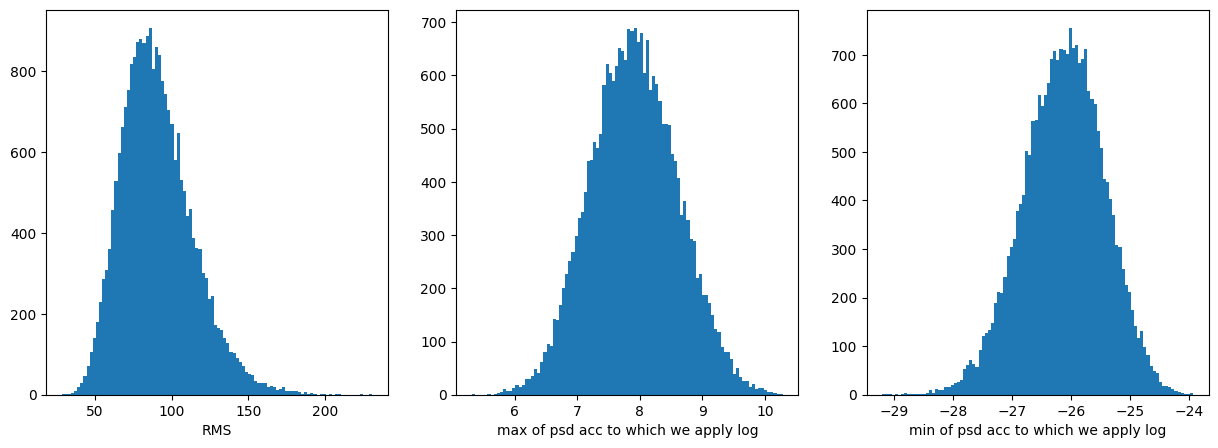

In [ ]:
#plot the histogram of the rms max and min in 3 different subplots
fig,ax = plt.subplots(ncols=3,figsize=(15,5))
ax[0].hist(rms,bins=100)
ax[0].set_xlabel('RMS')
ax[1].hist(max_sig,bins=100)
ax[1].set_xlabel('max of psd acc to which we apply log')
ax[2].hist(min_sig,bins=100)
ax[2].set_xlabel('min of psd acc to which we apply log')


In [ ]:
mean_rms = np.mean(rms)
mean_rms

90.77376243134972

# Effect of adding noise to the signal 

In [ ]:
def compute_psd(signal,fs,nperseg):
    f, psd = welch(signal, fs, nperseg=nperseg, scaling='spectrum')
    return f, psd

In [ ]:
def noise_std(SNR_dB:int,RMS_base:float=90):
    SNR_lin = 10**(SNR_dB/20)
    RMS_noise = RMS_base/SNR_lin
    std_noise = RMS_noise
    return std_noise

def generate_noise(SNR_dB:int,signal_length:int,RMS_base:float = 90):
    std_noise = noise_std(SNR_dB,RMS_base=RMS_base)
    noise = np.random.normal(0,std_noise,signal_length)
    return noise

def add_noise(signal,SNR_dB:int,RMS_base:float=90):
    noise = generate_noise(SNR_dB,signal_length=len(signal),RMS_base=RMS_base)
    return signal + noise

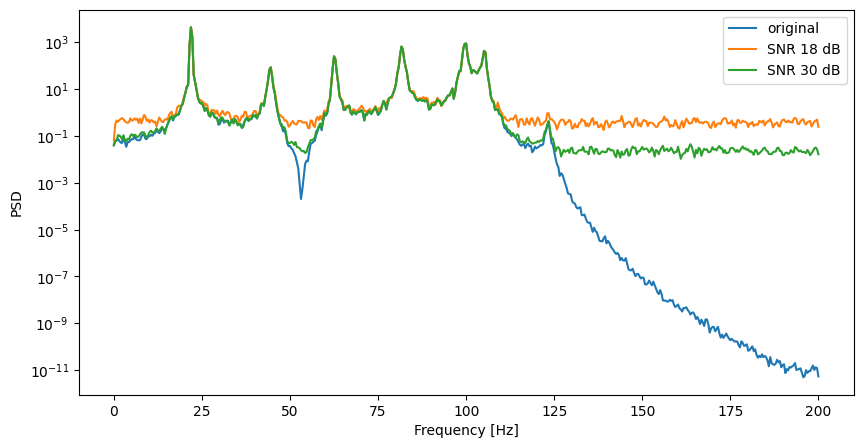

In [ ]:
import sqlite3
import numpy as np

# Connect to database and fetch the TDD_output
conn = sqlite3.connect(data_base_path)
c = conn.cursor()
c.execute("""SELECT TDD_output FROM simulation WHERE anomaly_level = 0""")
sig = c.fetchone()

# Reshape the output
TDD_output = np.frombuffer(sig[0], dtype=np.float64)
TDD_output = TDD_output.reshape((int(n_samples), -1))
acc_7 = TDD_output[:, 2*8+1]

# Create list of SNR levels and corresponding labels
SNR_levels = ["none", 18, 30]  
labels = ['original', 'SNR 18 dB', 'SNR 30 dB']

# Plot the results
fig, ax = plt.subplots(figsize=(10, 5))

# Iterate over SNR levels and labels
for snr, label in zip(SNR_levels, labels):
    # Add noise to the signal for non-zero SNR levels
    if snr != 'none':
        signal = add_noise(acc_7, SNR_dB=snr)
    else:
        signal = acc_7
    
    # Compute psd
    f, psd = compute_psd(signal, fs, 1024)
    
    # Plot the psd
    ax.plot(f, psd, label=label)

ax.set_yscale('log')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('PSD')
ax.legend()

plt.show()


# signal filtering

In [ ]:
from scipy import signal
import numpy as np

def preprocess_vibration_data(data, filter_order, lpf, sampling_frequency):
    # Step 1: Band-pass filtering
    # Design a Butterworth low-pass filter
    b, a = signal.butter(filter_order, lpf, 'low', fs=sampling_frequency)
    rms= np.sqrt(np.mean(np.square(data)))

    # Apply the filter to the data
    data_filtered = signal.lfilter(b, a, data)
    

    # Step 3: Signal conditioning
    # Subtract the mean and divide by the standard deviation
    conditioned_data = (data_filtered - np.mean(data_filtered)) / np.std(data_filtered)
    return conditioned_data, rms

def apply_welch(sig, sr:int,nperseg:int,noverlap:int|None=None):
    if noverlap is None:
        noverlap = nperseg // 2
    f, Pxx_den = signal.welch(sig, sr, nperseg=nperseg, noverlap=noverlap)
    return f, Pxx_den

def noise_std(SNR_dB:int,RMS_base:float=90):
    SNR_lin = 10**(SNR_dB/20)
    RMS_noise = RMS_base/SNR_lin
    std_noise = RMS_noise
    return std_noise

def generate_noise(SNR_dB:int,signal_length:int,RMS_base:float = 90):
    std_noise = noise_std(SNR_dB,RMS_base=RMS_base)
    noise = np.random.normal(0,std_noise,signal_length)
    return noise

def add_noise(signal,SNR_dB:int,RMS_base:float=90):
    noise = generate_noise(SNR_dB,signal_length=len(signal),RMS_base=RMS_base)
    return signal + noise




In [ ]:
import sqlite3
import numpy as np

# Connect to database and fetch the TDD_output
conn = sqlite3.connect(data_base_path)
c = conn.cursor()
c.execute("""SELECT TDD_output FROM simulation WHERE anomaly_level = 0""")
sig = c.fetchone()

# Reshape the output
TDD_output = np.frombuffer(sig[0], dtype=np.float64)
TDD_output = TDD_output.reshape((int(n_samples), -1))
acc_7 = TDD_output[:, 2*8+1]


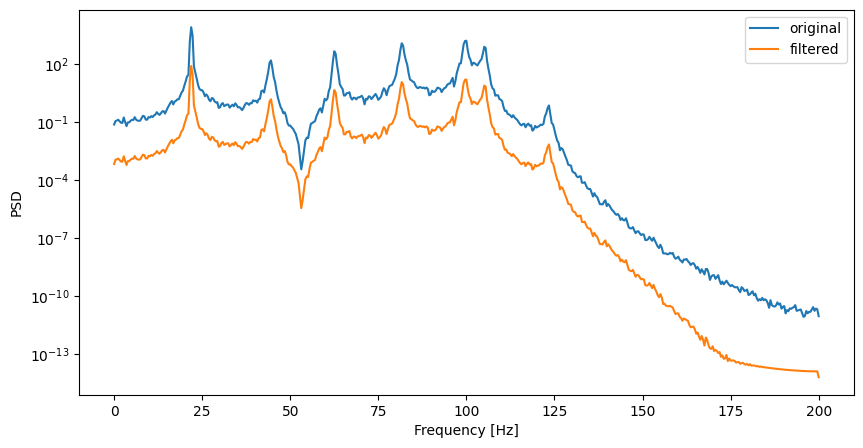

In [ ]:
acc_7_f, rms = preprocess_vibration_data(acc_7, filter_order=4, lpf=150, sampling_frequency=fs)
f,psd_f= apply_welch(acc_7_f,fs,nperseg=1024)
f_f,psd = apply_welch(acc_7,fs,nperseg=1024)
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(f,psd,label='original')
ax.plot(f_f,psd_f*rms, label='filtered') 
ax.set_yscale('log')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('PSD')
ax.legend()
